# Background-averaged interactions

# 3. Walsh–Hadamard Module

The **Walsh–Hadamard module** provides the mathematical foundation to decompose binary genotype–phenotype landscapes into orthogonal interaction modes of increasing order — from additive effects to higher-order epistasis.  

This module includes tools to:

- **Transform** a landscape into the **Walsh–Hadamard (WH) basis**, either through:  
  - A **Fast Walsh–Hadamard Transform (FWHT)** when the dataset is complete and ordered, or  
  - A **general projection** method that also works for incomplete or noisy data.  

- **Compute auxiliary quantities** such as:  
  - The binary and spin representations of states (`states_to_spins_shifted`).  
  - The binary domain $\{0,1\}^N$ and the interaction orders (`mode_orders`).  

- **Quantify epistatic contributions** via:  
  - `variance_spectrum(fs, orders)`: sums squared WH coefficients within each interaction order $k$ to measure their relative contribution to the total variance.  
  - `variance_decomposition(fs, orders, N)`: separates the total variance into interpretable components — *entropy* $H(k)$, *geometric decay* $4^{-k}$, and *interaction strength* $U(k)$ — showing how combinatorial structure and biological coupling shape the ecological function.  

---

### Conceptual Overview

The Walsh–Hadamard basis functions are defined as  
\begin{equation}
\phi_s(x) = (-1)^{s \cdot (x + 1)} ,
\end{equation}
where $x \in \{0,1\}^N$ is a genotype and $s$ indexes the interaction mode. Each coefficient  
\begin{equation}
f_s = 2^{-N} \sum_x F(x)\,\phi_s(x)
\end{equation}
captures the contribution of that mode to the overall function landscape.

- $|s| = 0$: global mean  
- $|s| = 1$: additive effects  
- $|s| = 2$: pairwise epistasis  
- $|s| > 2$: higher-order epistasis  

### Background-averaged interactions (interpretation)

Beyond being a purely algebraic decomposition, the WH coefficients admit a direct epistatic interpretation. For a subset of features $\mathbf{s}$ with size $|\mathbf{s}|=k$, the associated coefficient is proportional to the **background-averaged local $k$-way epistasis**:

\begin{equation}
f_{\mathbf{s}} = 2^{-k} \left( \frac{1}{2^{N-k}} \sum_{\mathbf{B} \in \{0,1\}^{N-k}} \varepsilon_{\mathbf{s}}(\mathbf{B})\right)
= 2^{-k}\,\langle \varepsilon_{\mathbf{s}}(\mathbf{B}) \rangle_{\mathbf{B}},
\end{equation}

where $\varepsilon_{\mathbf{s}}(\mathbf{B})$ denotes the **local** $k$-way epistatic interaction defined in the previous section, evaluated on a background configuration $\mathbf{B}$, and $\langle \cdot \rangle_{\mathbf{B}}$ denotes the uniform average over all backgrounds.

We will therefore refer to $\mathcal{E}_{\mathbf{s}} \equiv \langle \varepsilon_{\mathbf{s}}(\mathbf{B})\rangle_{\mathbf{B}}$
as the **interaction strength** associated with subset $\mathbf{s}$. In practice, WH analysis provides a convenient way to estimate these interaction strengths (or their order-wise aggregates) directly from empirical landscapes.


------

In short, this module connects **signal decomposition** and **biological interpretation**: it allows you to express a phenotype landscape as a structured hierarchy of additive and interactive components, and to quantify their relative importance through variance-based metrics.

## 3.1. Importing the required packages

In this tutorial, we will use:

- **`numpy`** — for numerical operations and array handling.  
- **`pandas`** — to manage and visualize tabular data.  
- **`matplotlib`** — for simple visualizations and plots.  
- **`epistasia`** — the main package used for representing and analyzing binary landscapes.

We will also define a small helper `header` function for formatted section headers, and adjust the Python path so the interpreter can find the `epistasia` package locally.

In [43]:
###########################
#         IMPORTS         #
###########################

import os
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('./style.mplstyle') #include plotsyle

###########################
#         HELPERS         #
###########################

# Simple header function for clean console output
def header(title):
    print("\n" + "=" * len(title))
    print(title)
    print("=" * len(title))

#############################################
#     LOAD BINARY LANDSCAPES DEPENDENCE     #
#############################################

# Include your local path to the library here
base_path = os.path.expanduser("~/FunEcoLab_IBFG Dropbox/")
sys.path.insert(1, base_path)

# Import the main package
import epistasia as ep

Let us define again our demo data frame and load it as a `Landscape` object

In [44]:
# --- Demo DataFrame ---
df = pd.DataFrame({
    "g0": [0, 0, 0, 1, 1, 1, 0, 1],
    "g1": [0, 0, 1, 0, 1, 1, 1, 0],
    "g2": [0, 1, 0, 0, 0, 1, 1, 1],
    "rep_1": [1.00, 1.10, 1.20, 1.30, np.nan, 1.50, 1.60, 1.70],
    "rep_2": [1.05, 1.12, np.nan, 1.28, 1.38, 1.48, 1.58, 1.68],
    "rep_3": [0.95, 1.08, 1.22, 1.33, 1.41, np.nan, 1.61, 1.69],
})

# --- Build a Landscape from the DataFrame ---
L = ep.Landscape.from_dataframe(df)  # N: total number of species -> inferred automatically
                                     # R: total number of replics -> inferred automatically

## 3.2. Walsh-Hadamard Transform

The *Walsh–Hadamard transform* decomposes the functional landscape into additive and interaction (epistatic) terms. It works like a Fourier transform for binary data: each coefficient $f_s$ measures how strongly a specific combination of genes (those with bits $s_i=1$) contributes to the phenotype.

When the **full landscape** is known (*i.e.* $M = 2^N$, all genotypes are measured), we can compute this decomposition efficiently using the [Fast Walsh–Hadamard Transform](https://en.wikipedia.org/wiki/Fast_Walsh%E2%80%93Hadamard_transform) (FWHT), which reuses intermediate sums instead of recalculating every mode separately. This is the approach used automatically below whenever the dataset is complete and contains no missing values.

If instead **some genotypes are missing** or contain NaNs, the package automatically switches to a **fallback projection method**. This slower approach projects the observed data onto the same shifted basis $\phi_s(x) = (-1)^{s·(x+1)}$ using only the available genotypes, ensuring consistent results even for incomplete landscapes.

<details>
  <summary><strong>Function documentation: <code>wh_transform</code></strong></summary>

  <div>

-------------------------------------------

### **Purpose**

Compute the **Walsh–Hadamard transform (WHT)** of a genotype–phenotype landscape.  
This function automatically selects between:

1. **Exact FWHT (Fast Walsh–Hadamard Transform)** — used only when:
   - the landscape is complete (contains all $2^N$ genotypes),
   - and has no missing values (no NaNs).

2. **Fallback projection** — used when:
   - the landscape is incomplete (missing genotypes),
   - or contains NaNs.

The function provides a unified interface so the user doesn't have to choose manually unless desired.

---

### **Inputs**

#### **`values : np.ndarray`**
Phenotype values of shape `(M,)` or `(M, R)`.  
If 1D, it is reshaped internally to `(M, 1)`.  
May contain NaNs (which triggers fallback mode).

#### **`states : np.ndarray`**
Genotype matrix of shape `(M, N)` with binary entries `{0,1}`.

#### **`N : int`**
Number of loci in the system.

#### **`strategy : {"auto", "fwht", "fallback"}`, default `"auto"`**
- `"auto"`:  
  Uses FWHT when the landscape is complete and NaN-free; otherwise uses fallback.
- `"fwht"`:  
  Forces exact FWHT; raises an error if impossible.
- `"fallback"`:  
  Forces approximate projection even if FWHT is available.

---

### **Outputs**

The function returns a 4-tuple:

#### **1. `fs` — Walsh–Hadamard coefficients**
Shape `(2^N,)` or `(2^N, R)` depending on input.  
If `values` was 1D, it is squeezed back to 1D.

#### **2. `s_bits` — Mode bits**
Array of shape `(2^N, N)` containing the binary representation of each Walsh mode.  
Each row corresponds to a vector  

\begin{equation}
s \in \{0,1\}^N.
\end{equation}

#### **3. `orders` — Interaction order of each coefficient**
Defined as

\begin{equation}
\text{order}(s) = \sum_{i=1}^N s_i.
\end{equation}

Thus:
- order 0 = baseline  
- order 1 = additive  
- order 2 = pairwise epistasis  
- …  
- order N = full N-way interaction

#### **4. `meta` — Metadata**
A dictionary describing what was done:

- `"path"` — `"fwht"` or `"fallback"`
- `"reordered"` — whether rows were lexicographically sorted
- `"mask_rows"` — boolean mask of included rows for fallback

---

### **Automatic logic**

The `"auto"` strategy follows:

if M == 2^N and values contain no NaNs:
    use FWHT (exact)
else:
    use fallback projection (approximate)

This guarantees the WHT is computable for any dataset.

------------

</details> 



In [45]:
# 1) Use replicate mean as the signal to transform
F_mean = L.mean_over_replicates()  # shape (M,)

# 2) WH transform (auto chooses FWHT if complete; fallback otherwise)
fs, s_bits, orders, meta = ep.wh_transform(F_mean, states=L.states, N=3, strategy="auto")
print("Path used:", meta["path"])  # 'fwht' or 'fallback'

# 3) Compact results table
out = pd.DataFrame(s_bits, columns=["s0","s1","s2"])
out["order"] = orders
out["f_s"] = fs
out = out.sort_values("order").reset_index(drop=True)
print(out)

print(r"$\langle F\rangle=$",F_mean.mean(),r"$=F_{(0,0,0)}=f_\vec{0}$")

Path used: fwht
   s0  s1  s2  order       f_s
0   0   0   0      0  1.348125
1   0   0   1      1  0.121042
2   0   1   0      1  0.074792
3   1   0   0      1  0.121458
4   0   1   1      2 -0.000625
5   1   0   1      2 -0.000625
6   1   1   0      2 -0.101875
7   1   1   1      3 -0.072292
$\langle F\rangle=$ 1.348125 $=F_{(0,0,0)}=f_\vec{0}$


Now we can remove some states from the demo data frame and run *wh_transform* again

In [46]:
# 1) Remove a few states (incomplete landscape)
drop_idx = [2, 5]                   # arbitrary rows to remove
df_inc = df.drop(index=drop_idx).reset_index(drop=True)

# 2) Build Landscape and standardize per replicate
states_inc = df_inc[["g0","g1","g2"]].values
values_inc = df_inc[["rep_1","rep_2","rep_3"]].values
L_inc = ep.Landscape(states_inc, values_inc, N=states_inc.shape[1], R=values_inc.shape[1])

# 3) Use replicate mean and run WH (auto → fallback)
F_mean_inc = L_inc.mean_over_replicates()
fs_inc, s_bits, orders, meta = ep.wh_transform(F_mean_inc, states=L_inc.states, N=3, strategy="auto")
print("Path used:", meta["path"])  # expected: 'fallback'

# 4) Compact results table
out_inc = pd.DataFrame(s_bits, columns=["s0","s1","s2"])
out_inc["order"] = orders
out_inc["f_s"] = fs_inc
out_inc = out_inc.sort_values("order").reset_index(drop=True)
print(out_inc.head(8))

Path used: fallback
   s0  s1  s2  order       f_s
0   0   0   0      0  1.347500
1   0   0   1      1  0.114722
2   0   1   0      1 -0.350278
3   1   0   0      1  0.115278
4   0   1   1      2 -0.047500
5   1   0   1      2 -0.450833
6   1   1   0      2 -0.182500
7   1   1   1      3 -0.546389


If we do not need the full WH transform we can also compute all coefficients $f_\mathbf{s}$ corresponding to a specific order $\mathcal{S}$, or even a single-mode coefficient if we are only interested in a particular average interaction. In the first example we work with the  average (across-replics) landscape

In [47]:
# 1 Get values and states from landscape object -> We use the average landscape
states = L.states
values = L.mean_over_replicates() 

# 2 Walsh–Hadamard transform (auto → FWHT)
fs, s_bits, orders, meta = ep.wh_transform(values, states, N=L.N)
print("Path used:", meta["path"])

# 3 Select coefficients for a specific order S (e.g., S=2)
S = 2
mask_S = (orders == S)
fs_order2 = fs[mask_S]
s_modes_S2 = s_bits[mask_S]

print(f"\nCoefficients for order S={S}:")
for s_vec, f_val in zip(s_modes_S2, fs_order2):
    print(f"s={s_vec}  |  f_s={f_val:.4f}")

# 4 Extract a single coefficient for a given s (e.g., s = [1,0,1])
target_s = np.array([1, 0, 1])
mask_single = np.all(s_bits == target_s, axis=1)
f_target = fs[mask_single][0]

print(f"\nSingle coefficient for s={target_s.tolist()}: f_s = {f_target:.4f}")


Path used: fwht

Coefficients for order S=2:
s=[0 1 1]  |  f_s=-0.0006
s=[1 0 1]  |  f_s=-0.0006
s=[1 1 0]  |  f_s=-0.1019

Single coefficient for s=[1, 0, 1]: f_s = -0.0006


Alternatively, we can compute the WH proyection for every replic all at once

In [48]:
# 1 Get values and states from landscape object -> Now we keep all replics
states = L.states
values = L.values            # shape (M, R)

# WH on all replicates → fs is (2^N, R)
fsR, s_bits, orders, meta = ep.wh_transform(values, states=states, N=L.N, strategy="auto")
print("Path used:", meta["path"])
print("fs shape:", fsR.shape)  # (2^N, R)

# Select order S across all replicates (e.g., S=2)
S = 2
mask_S = (orders == S)
fs_order2 = fsR[mask_S, :]      # shape (num_modes_S, R)
s_modes_S2 = s_bits[mask_S, :]

# Pretty table: rows=modes of order S, cols=replicates
cols = [f"rep{j}" for j in range(fs_order2.shape[1])]
df_S = pd.DataFrame(fs_order2, columns=cols)
df_S.insert(0, "s", [tuple(s) for s in s_modes_S2])
print(df_S)

# Single coefficient for a chosen s across replicates (vector of length R)
target_s = np.array([1,0,1])
mask_single = np.all(s_bits == target_s, axis=1)
f_target_all = fsR[mask_single, :].ravel()   # shape (R,)
print(f"\nCoefficients for s={target_s.tolist()} per replicate:", f_target_all)

# Optional: summarize across replicates
print("mean ± sd:", f_target_all.mean(), "±", f_target_all.std(ddof=1))


Path used: fallback
fs shape: (8, 3)
           s  rep0   rep1   rep2
0  (0, 1, 1)  0.22  0.222  0.224
1  (1, 0, 1) -0.26 -0.250 -0.276
2  (1, 1, 0) -0.50 -0.474 -0.520

Coefficients for s=[1, 0, 1] per replicate: [-0.26  -0.25  -0.276]
mean ± sd: -0.262 ± 0.013114877048604017


## 3.3. Statistics of the coefficients

`walsh_analysis` is the statistical wrapper around the `Walsh–Hadamard` transform. It computes WH coefficients $f_\mathbf{s}$ (internally calling wh_transform or the fallback projection), then optionally performs bootstrap-based uncertainty estimation and null-model testing so you get point estimates plus confidence intervals, sign probabilities and global null tests.

<details>
  <summary><strong>Function documentation: <code>walsh_analysis</code></strong></summary>

  <div>

--------------------------------------------

### **Purpose**

Compute **Walsh–Hadamard coefficients** $f_\mathbf{s}$ for all modes $\mathbf{s} \in \{0,1\}^N$, including:

- replicate-level coefficients,
- summary statistics (mean, experimental and biological SD),
- bootstrap-based **uncertainty bands**,
- **null-model tests** and signal-to-noise ratios,

mirroring the APIs of `focal_effect` and `epistasis_k`.

This function is the main entry point to analyze the **global structure** of the landscape in Walsh space.

---

### **Inputs**

#### `L : Landscape`

Landscape object with:

- `L.states` — genotypes, shape $(M, N)$ with entries in $\{0,1\}$  
- `L.values` — replicate phenotype values, shape $(M, R)$

At least **2 replicates** are required if any bootstrap is enabled.

---

### **Robustness options**

These are passed to the internal cleaning routine `_clean_landscape_for_wh`:

- **`missing_policy : {"error","drop"}`, default `"error"`**  
  Reserved for future handling of incomplete landscapes; currently used only for basic sanity checks during cleaning.

- **`nan_policy : {"omit","propagate"}`, default `"omit"`**  
  How to treat NaNs before computing the transform:
  - `"omit"`: handle NaNs in a robust way (e.g. replacing by 0 for the transform).  
  - `"propagate"`: NaNs are allowed to propagate into the coefficients when appropriate.

---

### **Bootstrap options**

#### **Uncertainty bootstrap** (around the inferred landscape $\hat F$)

- **`B_uncertainty : int`, default $0$**  
  Number of bootstrap draws to estimate the sampling distribution of $f_s$.

- **`uncertainty_flavor : {"iid","wildcluster"}`, default `"iid"`**  
  - `"iid"`: bootstrap each state independently.  
  - `"wildcluster"`: preserve replicate-level covariance (recommended when biological correlations exist).

This produces:

- per-mode **uncertainty CIs**: `ci_low`, `ci_high`  
- **sign probabilities**: `sign_prob_pos`, `sign_prob_neg`  
  giving $\Pr(f_s > 0)$ and $\Pr(f_s < 0)$.

---

#### **Null bootstrap** (noise-only model in Walsh space)

- **`B_null : int`, default `0`**  
  Number of bootstrap samples drawn from an **observed null model**:
  landscapes with no biological signal but realistic measurement noise.

- **`consider_bio_corr : bool`, default `False`**  
  - `False`: i.i.d. null — breaks cross-state correlations.  
  - `True`: wild-cluster null — preserves empirical cross-state covariance.

- **`multipliers : {"rademacher","normal"}`, default `"rademacher"`**  
  Distribution of wild bootstrap multipliers.

- **`ci_level : float`, default `0.95`**  
  Confidence level used for both uncertainty and null CIs.

- **`rng : np.random.Generator | None`**  
  Optional RNG for reproducibility.

The null bootstrap yields:

- per-mode **null CIs**: `null_ci_low`, `null_ci_high`  
- **global variance test across modes**:  
  - `var_obs` — observed variance of `mean` across modes  
  - `var_null_median` — median variance under null  
  - `p_value_var` — \(\Pr(\mathrm{Var}_{\text{null}} \ge \mathrm{Var}_{\text{obs}})\)  
  - `effect_size_var` — difference between observed and typical null variance  
- **per-mode signal-to-null-noise ratio**: `snr_null`

---

### **Output options**

- **`as_dataframe : bool`, default `True`**

Controls the return type:

- If `True`: returns a **tidy DataFrame** (pretty format) with one row per Walsh mode.  
- If `False`: returns a `WalshResults` dataclass with all numerical arrays and metadata.

---

### **Returned object**

Depending on `as_dataframe`:

#### **1. If `as_dataframe=True`**

A `pd.DataFrame` summarizing for each mode:

- Walsh index and binary pattern (`s_bits`, `orders`)  
- `Walsh coefficient (mean)`  
- `Experimental SD`, `Biological SD`  
- `Uncertainty CI (low)`, `Uncertainty CI (high)` (if `B_uncertainty > 0`)  
- `Null CI (low)`, `Null CI (high)` (if `B_null > 0`)  
- `Signal-to-Null-Noise (SNR)`  
- `P-value (variance excess)` and related null-test fields (if `B_null > 0`)  
- Sign probabilities (`Prob(Effect > 0)`, `Prob(Effect < 0)`)

This format is ideal for plotting spectra, filtering modes, or exporting results.

#### **2. If `as_dataframe=False`**

A `WalshResults` object with:

- `values` — replicate-level coefficients \(f_s^{(r)}\)  
- `mean`, `std_experimental`, `std_biological`  
- `s_bits`, `orders` — structural information about each mode  
- `ci_low`, `ci_high`, `null_ci_low`, `null_ci_high`  
- `sign_prob_pos`, `sign_prob_neg`, `snr_null`  
- `var_obs`, `var_null_median`, `p_value_var`, `effect_size_var`  
- `meta` — dictionary with all settings and bootstrap arrays (`fs_unc_b`, `fs_null_b`, etc.)  
- `feature_names` — copied from `L.feature_names` if present

---
  </div>
</details>


In [49]:
df_wh = ep.walsh_analysis(
    L,
    missing_policy="error",
    nan_policy="omit",
    B_uncertainty=500,          # uncertainty bootstrap
    B_null=500,                 # null bootstrap
    multipliers="normal",
    ci_level=0.95,
    as_dataframe=True,          # return a pretty DataFrame
)

display(df_wh)

,Mode bits,Mode (features),Order,Walsh (mean),Experimental SD,Biological SD,Uncertainty CI (low),Uncertainty CI (high),Prob(fs > 0),Prob(fs < 0),Null CI (low),Null CI (high),Signal-to-Null-Noise (SNR),Variance (observed),Variance (null median),P-value (variance excess),p-null
0,000,∅,0,1.338000,0.005292,0.003055,1.338000,1.338000,1.0,0.0,-1.387779e-18,1.387779e-18,2.149511e+18,0.425788,0.000036,0.0,0.0
1,001,g2,1,0.416667,0.005774,0.003333,0.400519,0.431538,1.0,0.0,-1.515027e-02,1.793080e-02,5.195464e+01,0.425788,0.000036,0.0,0.0
2,010,g1,1,-0.699333,0.011015,0.006360,-0.712155,-0.687033,0.0,1.0,-1.284724e-02,1.314451e-02,1.127026e+02,0.425788,0.000036,0.0,0.0
3,011,"g1,g2",2,0.222000,0.002000,0.001155,0.207007,0.237842,1.0,0.0,-1.757527e-02,1.701133e-02,2.845047e+01,0.425788,0.000036,0.0,0.0
4,100,g0,1,-0.140667,0.017010,0.009821,-0.158753,-0.124360,0.0,1.0,-1.654093e-02,1.627396e-02,1.821769e+01,0.425788,0.000036,0.0,0.0
5,101,"g0,g2",2,-0.262000,0.013115,0.007572,-0.277206,-0.246220,0.0,1.0,-1.610845e-02,1.662822e-02,3.456896e+01,0.425788,0.000036,0.0,0.0
6,110,"g0,g1",2,-0.498000,0.023065,0.013317,-0.513211,-0.480557,0.0,1.0,-1.541200e-02,1.476218e-02,6.674164e+01,0.425788,0.000036,0.0,0.0
7,111,"g0,g1,g2",3,-0.376667,0.007572,0.004372,-0.393415,-0.360340,0.0,1.0,-1.677076e-02,1.308883e-02,4.980233e+01,0.425788,0.000036,0.0,0.0


## 3.4. Other dependences

### binary_domain and mode_orders

**A.** Generates **all binary combinations** of indices $s \in \{0,1\}^N$ and their Hamming weights $|s|$.  
Useful to map each coefficient $f_s$ to its interaction order (additive, pairwise, triple, etc.).


In [50]:
# Build all WH mode indices s in {0,1}^N and their orders |s|
N = 3
s_bits = ep._binary_domain(N)    # shape (2^N, N)
orders = ep.mode_orders(N)      # shape (2^N,)
print(s_bits)
print(orders)  # e.g., [0,1,1,2,1,2,2,3]

[[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
[0 1 1 2 1 2 2 3]


### states_to_spins_shifted

**B.** Converts binary genotypes $\{0,1\}^N$ into “spins” $\{-1,+1\}$ under the shifted convention.  
This is the base representation used to construct any WH basis function $\phi_s(x)$.

In [51]:
# Map states {0,1}^N to spins z_i(x) in {-1,+1} with the shifted convention
states = np.array([[0,0,0],[0,0,1],[1,1,0]])
Z = ep.states_to_spins_shifted(states)
# Now any φ_s(x) = product of columns Z[:, i] where s_i==1

print(Z)

[[-1. -1. -1.]
 [-1. -1.  1.]
 [ 1.  1. -1.]]


### Lexicographic ordering

**C.** Ensures that genotypes are lexicographically ordered before applying the FWHT.  
If the input states are unordered, `wh_transform` reorders them internally and flags this in `meta["reordered"]`.

In [52]:
# 1 Get values and states from landscape
states = L.states
values = L.values
N = L.N

# 2 Apply WH transform (auto strategy)
fs, s_bits, orders, meta = ep.wh_transform(values, states, N=N, strategy="auto")

# 3 Check whether the states were reordered
print("Path used:", meta["path"])          # 'fwht' for full landscape
print("Reordered by function:", meta["reordered"])  # True if sorting was applied

# 4 Confirm lexicographic ordering after sorting
sorted_states = ep._binary_domain(3)  # {0,1}^3 in lex order
print("First and last sorted states:")
print(sorted_states[0], sorted_states[-1])


Path used: fallback
Reordered by function: False
First and last sorted states:
[0 0 0] [1 1 1]


## 3.5. Epistasis amplitude 

<details>
  <summary><strong>Function documentation: <code>epistasis_amplitude</code></strong></summary>

  <div>

### **Purpose**

Compute the **epistasis amplitude spectrum**  
\begin{equation}
\langle E^2 \rangle_k,\quad k = 1,2,\dots,N
\end{equation}
including:

- point estimates from the Walsh–Hadamard coefficients of the empirical landscape,
- **uncertainty bootstrap** (around the inferred phenotype),
- **null bootstrap** (noise-only epistasis spectrum),
- per–order **confidence intervals**, **SNR**, and **global variance tests**.

This is the amplitude decomposition used in the literature (e.g. Otwinowski et al., Neidhart et al., Husain & Murugan),
and fully matches the statistical structure of `epistasis_k`, `focal_effect`, and `walsh_coefficients`.

---

### **Definition**

For each interaction order $k \ge $1$$:

\begin{equation}
\langle E^2 \rangle_S \;=\; \frac{4^k}{\binom{N}{k}} 
\sum_{\lvert s \rvert = S} f_s^2,
\end{equation}

where:

- $f_s$ = Walsh–Hadamard coefficient of mode $s$,
- $\lvert s\rvert$ = interaction order $k$,
- the sum is over all modes with Hamming weight $k$,
- the prefactor $4^k$ rescales the Walsh variance to biological epistasis amplitude.

This produces **one number per order**, summarizing how much epistatic variance is present at each interaction scale.

---

### **Inputs**

#### `L : Landscape`
Landscape with:
- `L.states` — genotype matrix `(M, N)`
- `L.values` — replicate matrix `(M, R)`

Requires `R ≥ 2` if bootstraps are enabled.

---

### **Robustness options**

- **`missing_policy : {"error","drop"}`**  
  Used in cleaning; currently validation only.

- **`nan_policy : {"omit","propagate"}`**  
  Forwarded to `_clean_landscape_for_wh()`.

---

### **Uncertainty bootstrap**

Parameters:

- `B_uncertainty` — number of bootstrap samples  
- `uncertainty_flavor : {"iid","wildcluster"}`  
- `multipliers : {"rademacher","normal"}`  
- `ci_level` — confidence level  
- `rng` — optional RNG

Produces for each order $S$:

- `CI low`, `CI high` — bootstrap confidence intervals  
- distribution of amplitude fluctuations under measurement noise

This captures **uncertainty in $\hat F$**.

---

### **Null bootstrap**

Parameters:

- `B_null` — number of null samples  
- `consider_bio_corr` — preserve vs. remove biological covariance  
- `multipliers`  
- `ci_level`

Produces for each order $k$:

- `Null CI low`, `Null CI high`  
- `SNR (null)` — detection strength:  
  \[
  \text{SNR}_k = \frac{\langle E^2\rangle_k}{\sigma_k^{\text{null}}}
  \]
- global variance test across orders:
  - `Variance (obs)`
  - `Variance (null median)`
  - `P-value var`

This tests **whether the amplitude structure exceeds what noise alone produces**.

---

### **Output**

#### If `as_dataframe=True` (default)

A tidy table:

| Order | Epistasis amplitude | CI low | CI high | Null CI low | Null CI high | SNR(null) | … |

One row per interaction order $k$.

#### If `as_dataframe=False`

A dict:

```python
{
    "orders": array([...]),
    "amplitude": array([...]),
    "ci_low": ...,
    "ci_high": ...,
    "null_ci_low": ...,
    "null_ci_high": ...,
    "snr_null": ...,
    "var_obs": ...,
    "var_null_median": ...,
    "p_value_var": ...
}
```
This yields the epistasis spectrum, uncertainty, null model, and strengths of detection for every order $k$.

----------------------------------------

</div> </details> 

In the Walsh–Hadamard (WH) basis, each coefficient $f_s$ corresponds to a subset of loci $s$ with interaction order $|s| = S$. For that subset, we defined the **interaction strength** $\mathcal{E}_s$ as the average $k$-way epistatic effect across all possible backgrounds. Under the shifted WH convention, it relates to the WH coefficient as:

\begin{equation}
f_s = 2^{-|k|} \mathcal{E}_k.
\end{equation}

The **epistasis amplitude** at order $S$ is the second moment of the interaction strengths for all subsets of size $k$

\begin{equation}
\langle\mathcal{E}^2\rangle_k \equiv  {\binom{N}{k}}^{-1} \sum_{\substack{\mathbf{s} \\ |\mathbf{s}|=k}} \mathcal{E}_\mathbf{s}^2 \; .
\end{equation}

The notation $\langle \cdot \rangle_k$ hereafter denotes averaging across all $k$-order backgrounds. 

Using the definitions above, the function `epistasis_amplitude` computes the order-specific epistasis amplitude directly from the WH coefficients, together with optional bootstrap uncertainty and a noise-only null model. The example below shows how to obtain a tidy, ready-to-analyze DataFrame summarizing these quantities for all interaction orders in the landscape.



In [53]:
df_amp = ep.epistasis_amplitude(
    L,
    B_uncertainty=500,          # uncertainty bootstrap
    B_null=500,                 # null bootstrap
    ci_level=0.95,
    multipliers="rademacher",
    as_dataframe=True,          # return a tidy DataFrame
)
display(df_amp)

,Order,Epistasis amplitude <E^2>_k,CI low,CI high,Null CI low,Null CI high,SNR (null),Null mean,Variance (obs),Variance (null median),P-value order,P-value var
0,1,0.909954,0.891412,0.929595,0.000016,0.000542,5992.144454,0.000216,0.909954,0.000187,0.0,0.0
1,2,1.951637,1.855587,2.051518,0.000060,0.002371,3024.374322,0.000992,1.951637,0.000921,0.0,0.0
2,3,9.080178,8.357318,9.821824,0.000015,0.018851,1837.911456,0.003950,9.080178,0.001973,0.0,0.0


## 3.6. Decomposition of functional variance

The total functional variance of a binary landscape can be decomposed into contributions arising from different interaction orders between genes. Using the Walsh–Hadamard basis, the landscape $F(\mathbf{x})$ can be expressed as

\begin{equation}
F(\mathbf{x}) = \sum_{s \in \{0,1\}^N} f_s \, \phi_s(\mathbf{x}),
\end{equation}

where each coefficient $f_s$ quantifies the contribution of the combination of loci in $s$. The total functional variance (excluding the global mean) is:

\begin{equation}
V_{\text{tot}} = \sum_{s \neq 0} f_s^2.
\end{equation}

Grouping coefficients by their Hamming weight $|s| = \mathcal{S}$ gives the variance spectrum:

\begin{equation}
V(S) = \sum_{|s| = \mathcal{S}} f_s^2,
\end{equation}

which measures how much of the phenotypic variance is explained by interactions involving $\mathcal{S}$ loci. 

In the example bellow we illustrate how to use *binary landscapes* to compute de variance spectrum by interaction orders

Path used: fwht


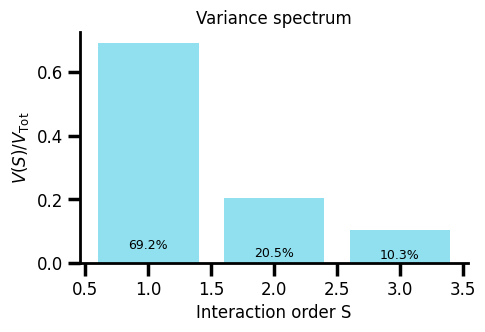

In [54]:
# 1- Walsh–Hadamard transform (auto decides FWHT or fallback)
fs, s_bits, orders, meta = ep.wh_transform(F_mean, states=L.states, N=3)
print("Path used:", meta["path"])  # should be 'fwht' for this full landscape

# 2- Compute variance spectrum and decomposition
V_S = ep.variance_spectrum(fs, orders)

# 3- Plot

# Collect S and values in order
S = sorted(V_S.keys())
vals = np.array([ (V_S[s][0] if np.ndim(V_S[s]) else V_S[s]) for s in S ])
Vtot = vals.sum()

plt.figure(figsize=(5,3))
bars = plt.bar(S, vals/Vtot,color="#90e0ef")
plt.xlabel("Interaction order S")
plt.ylabel(r"$V(S)/V_{\text{Tot}}$")
plt.title("Variance spectrum")

# annotate percentages above bars
for x, v in zip(S, vals):
    if v > 0:
        plt.text(x, v, f"{100*v/Vtot:.1f}%", ha="center", va="bottom", fontsize=9)


A concentration of variance at low orders indicates that the landscape is dominated by low-order interactions. In particular, a strong order-1 contribution suggests a largely additive structure, while significant weight at higher orders reflects epistatic effects involving multiple features.

In order to make more explicit the relation between the variance decomposition and interaction order, we can introduce the interaction strength

\begin{equation}
f_{\mathbf{s}} =  2^{-|\mathbf{s}|} \mathcal{E}_\mathbf{s} 
\end{equation}

in the expresion for the variance expression

\begin{equation}
V(k) = 4^{-k}\sum_{\substack{\mathbf{s} \\ |\mathbf{s}|=k}} \mathcal{E}^2_\mathbf{s}=4^{-k}\binom{N}{k}\langle\mathcal{E}^2\rangle_k \; ,
\end{equation}

The variance decomposition includes three differnte contributions

- **$\binom{N}{k}$** — *entropy term*, counting the number of independent configurations at order $k$.  
- **$4^{-k}$** — *geometric decay*, accounting for the scaling of higher-order configurations.  
- **$\langle \mathcal{E}^2 \rangle_k$** — *epistasis amplitude*, representing the average magnitude of true epistatic effects at that order.  


*epistasia* allows for explict computation of this decomposition using *variance_decomposition*

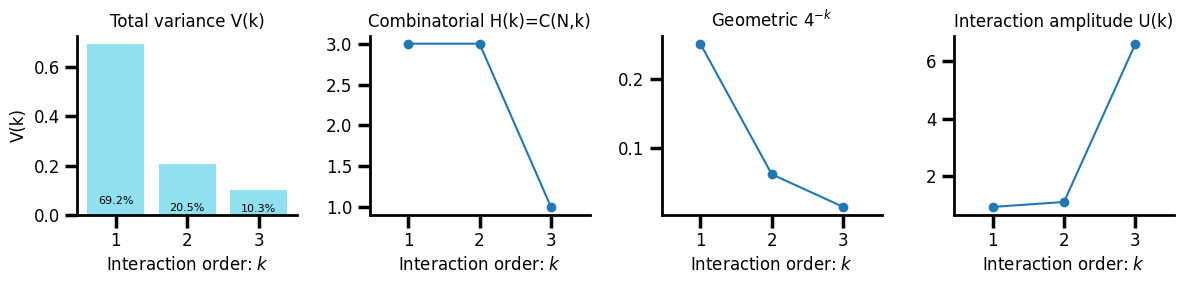

In [55]:
# 1) Compute decomposition from fs (already computed) and orders, with N loci
dec = ep.variance_decomposition(fs, orders, N=3)  # returns dict[k]: {"H","geom","U","V"}

# 2) Collect series in order of k
S = sorted(dec.keys())
H   = np.array([dec[s]["H"][0]   if np.ndim(dec[s]["H"])   else dec[s]["H"]   for s in S], dtype=float)
geom= np.array([dec[s]["geom"][0]if np.ndim(dec[s]["geom"])else dec[s]["geom"]for s in S], dtype=float)
U   = np.array([dec[s]["U"][0]   if np.ndim(dec[s]["U"])   else dec[s]["U"]   for s in S], dtype=float)
V   = np.array([dec[s]["V"][0]   if np.ndim(dec[s]["V"])   else dec[s]["V"]   for s in S], dtype=float)

Vtot = V.sum()

# 3) Make subplots
fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharex=True)

# (a) Total variance spectrum V(k)
axes[0].bar(S, V/Vtot,color="#90e0ef")
axes[0].set_title("Total variance V(k)")
axes[0].set_xlabel("Interaction order: "+r"$k$")
axes[0].set_ylabel("V(k)")
if V.sum() > 0:
    for x, v in zip(S, V):
        if v > 0:
            axes[0].text(x, v, f"{100*v/V.sum():.1f}%", ha="center", va="bottom", fontsize=8)

# (b) Combinatorial term H(k) = C(N,k)
axes[1].plot(S, H)
axes[1].scatter(S, H)
axes[1].set_title("Combinatorial H(k)=C(N,k)")
axes[1].set_xlabel("Interaction order: "+r"$k$")

# (c) Geometric factor 4^{-k}
axes[2].plot(S, geom)
axes[2].scatter(S, geom)
axes[2].set_title("Geometric 4$^{-k}$")
axes[2].set_xlabel("Interaction order: "+r"$k$")

# (d) Interaction amplitude U(k) = <E_s^2>_k
axes[3].plot(S, U/Vtot)
axes[3].scatter(S, U/Vtot)
axes[3].set_title("Interaction amplitude U(k)")
axes[3].set_xlabel("Interaction order: "+r"$k$")

plt.tight_layout()
plt.show()

## 3.7. Statistics of the functional variance

<details>
  <summary><strong>Function documentation: <code>variance_by_order_statistics</code></strong></summary>

  <div>

### **Purpose**

Compute the **variance decomposition by interaction order**:

\begin{equation}
V(S) \;=\; \sum_{\lvert s\rvert = S} f_s^2,
\end{equation}

where $f_s$ are the Walsh–Hadamard coefficients and $S = 1,2,\dots,N$.  
This gives the **amount of phenotypic variance** contributed by epistatic interactions of each order.

The function supports:

- **uncertainty bootstrap** (around the inferred phenotype $\hat F$),
- **null bootstrap** (noise-only landscapes),
- **confidence intervals** for both uncertainty and null,
- **SNR per order**,
- **global variance test** across orders,  
- option to normalize the spectrum as  

\begin{equation}
V_{\mathrm{frac}}(S) = \frac{V(S)}{\sum_T V(T)}
\end{equation}

producing a **fractional epistasis spectrum**.

---

### **Definitions**

#### **Variance by interaction order**

\begin{equation}
V(S) = \sum_{|s|=S} f_s^2
\end{equation}

This reflects how much epistasis exists at order \(S\).  
It is the **biologically standard variance decomposition**.

#### **Fraction of variance (optional)**

If `as_fraction=True`:

\begin{equation}
v_{\mathrm{frac}}(S) = \frac{V(S)}{\sum_T V(T)}.
\end{equation}

This shows **what percentage** of total epistatic variance belongs to each order.

---

### **Inputs**

#### Required
- `L : Landscape`
  - `L.states` — binary matrix `(M, N)`
  - `L.values` — replicates `(M, R)`
- Complete or incomplete landscapes supported (fallback projector is used).

#### Robustness options
- **`missing_policy : {"error","drop"}`**  
  How to handle missing states for WH projection.
- **`nan_policy : {"omit","propagate"}`**  
  How to treat NaNs before the transform.

#### Bootstrap options
Same API and meaning as in your other functions:

- `B_uncertainty` — bootstraps around \(\hat F\)
- `uncertainty_flavor : {"iid","wildcluster"}`
- `B_null` — noise-only bootstraps
- `consider_bio_corr : bool`
- `multipliers : {"rademacher","normal"}`
- `ci_level`
- `rng`

#### Output control
- `as_fraction=True` → return normalized spectrum \(V_{\mathrm{frac}}(S)\).
- `as_dataframe=True` → return tidy table (recommended).

---

### **Outputs**

If `as_dataframe=True`, returns:

| Order | Variance V(S) or Fraction | CI low | CI high | Null CI low | Null CI high | SNR(null) | Variance (obs) | Variance (null median) | P-value var |

- **Per-order uncertainty CI**  
- **Per-order null CI**  
- **SNR vs null**  
- **Global variance excess test** (across orders)

If `as_dataframe=False`, returns an equivalent raw dictionary.

---

### **Interpretation**

- High **V(S)** → strong epistasis at order S  
- High **SNR(null)** → order S is reliably detected above noise  
- **Null CIs** tell what spectrum you'd expect **from noise only**  
- **Global p-value** tests whether the pattern across S is more structured than noise  

This is extremely useful to characterize:
- landscapes dominated by low-order interactions,
- globally epistatic landscapes (rank-1-like),
- idiosyncratic high-order epistasis,
- landscapes near your Kuramoto + exclusion or Ising-like generative models.

------------------

Notes

Order $\mathcal{S}=0$ (the global mean) is automatically removed.

Works seamlessly with incomplete landscapes via the fallback WH projection.

Statistical behaviour fully matches your other modules (epistasis, WH, null tests).

-----------------

</div>
</details> 

After defining how the total functional variance decomposes across interaction orders, the next step is to quantify the statistical uncertainty associated with these estimates. The function `variance_by_order_statistics` computes confidence intervals, null-model expectations, and p-values for each order-specific variance component. This allows us to assess which interaction orders contribute significantly beyond what would be expected from measurement noise alone. The example below shows how to obtain these statistics in a compact and analysis-ready format.


In [56]:
# Total variance per order
df_V = ep.variance_by_order_statistics(
    L,
    B_uncertainty=500,
    B_null=500,
    as_fraction=True, # return as fraction of total variance
    rng=np.random.default_rng(123),
    ci_method_uncertainty = "percentile",  # {"percentile","studentized","bca"}
)
display(df_V)


,Order,Fraction of variance V(S)/sum_T V(T),CI low,CI high,Null CI low,Null CI high,SNR (null),Variance (obs),Variance (null median),P-value var,P-value order
0,1,0.573368,0.558567,0.587703,3.053187e-06,0.000586,3315.690761,0.573368,0.000065,0.0,0.0
1,2,0.307435,0.290673,0.326266,4.131924e-06,0.000638,1742.204474,0.307435,0.000083,0.0,0.0
2,3,0.119197,0.108568,0.130313,2.007454e-08,0.000416,863.284543,0.119197,0.000013,0.0,0.0


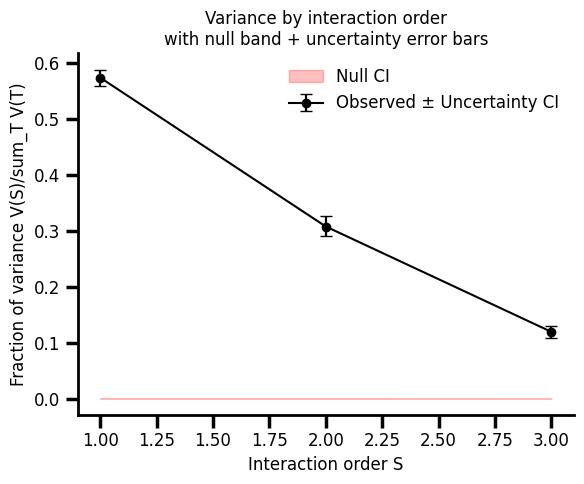

In [57]:
orders = df_V["Order"].values
Q = df_V.iloc[:, 1].values                      # observed quantity
ci_low = df_V["CI low"].values
ci_high = df_V["CI high"].values
null_low = df_V["Null CI low"].values
null_high = df_V["Null CI high"].values

fig, ax = plt.subplots(figsize=(6, 5))

# -----------------------------------
# 1) Null interval as shaded band
# -----------------------------------
ax.fill_between(
    orders,
    null_low,
    null_high,
    color="red",
    alpha=0.25,
    label="Null CI"
)

# -----------------------------------
# 2) Observed value with uncertainty error bars
# -----------------------------------
ax.errorbar(
    orders,
    Q,
    yerr=[Q - ci_low, ci_high - Q],
    fmt="o-",
    color="black",
    ecolor="black",
    elinewidth=1.6,
    capsize=4,
    label="Observed ± Uncertainty CI"
)

# -----------------------------------
# Formatting
# -----------------------------------
ax.set_xlabel("Interaction order S")
ax.set_ylabel(df_V.columns[1])   # fraction of variance or total variance
ax.set_title("Variance by interaction order\nwith null band + uncertainty error bars")
ax.legend(frameon=False)
#ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3.8. Epistasis amplitude



In [58]:
df_Ea = ep.epistasis_amplitude(
    L,
    B_uncertainty=500,
    B_null=500,
    rng=np.random.default_rng(12345),
    ci_method_uncertainty = "percentile"  # {"percentile","studentized","bca"}
)
display(df_Ea)

,Order,Epistasis amplitude <E^2>_k,CI low,CI high,Null CI low,Null CI high,SNR (null),Null mean,Variance (obs),Variance (null median),P-value order,P-value var
0,1,0.909954,0.887179,0.932470,0.000003,0.000891,3416.216033,0.000196,0.909954,0.000100,0.0,0.0
1,2,1.951637,1.836885,2.076055,0.000015,0.003583,1987.963096,0.000896,1.951637,0.000541,0.0,0.0
2,3,9.080178,8.381780,9.900077,0.000002,0.024735,1239.734554,0.004226,9.080178,0.001219,0.0,0.0
